In [31]:
Image(url='http://www.teamnetwork.org/files/home/team-header-1000.gif')

## Problem Statement

Conservation Internaitonal's TEAM has labeled camera trap images of terrestial mammals

- Images require manual classification from experts in the field
- Many of the images are misclassified
- There is a class of unlabeled images
- There is a class of unknown images

## Wildlife Image Classification Literature Review
1. SVM Models
2. Learning Models (Convolutional Neural Network)

## Image Segmentation

- Manual Cropping
- Image Segmentation with Graph Cut 
http://cmp.felk.cvut.cz/~smidm/python-packages-for-graph-cuts-on-images.html


## Feature Extraction
- Template Matching
- Histogram Matching
- Scale Invariant Feature Transform (SIFT)
- Cell-structured Local Binary Pattern (cLBP) descriptor
- Fisher Vector Coding
- Spatial Pyramid Strategy

## Set Up

In [2]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -u -n -v -p pandas,numpy,keras,cv2,sift_pyocl,cyvlfeat,PIL,sklearn,matplotlib -m

Using TensorFlow backend.


last updated: Thu Dec 15 2016 

CPython 3.5.2
IPython 5.1.0

pandas 0.19.1
numpy 1.11.2
keras 1.1.2
cv2 3.1.0
sift_pyocl 0.3.0
cyvlfeat 0.4.5
PIL 3.4.2
sklearn 0.18.1
matplotlib 1.5.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


## Experiments

In [3]:
import pandas as pd
import numpy as np
import os
import PIL
import sift_pyocl # uses pyOpenCL to access GPUs and other massively parallel compute devices from Python
import cyvlfeat as vl # a Python (cython) wrapper of the popular VLFeat library
import cv2

import scipy.misc # ensure this is imported before keras/tensorflow: https://github.com/carpedm20/DCGAN-tensorflow/issues/16

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import Math

os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

ROWS = 180  #720
COLS = 320 #1280
CHANNELS = 3
SPECIES_CLASSES = ['Loxodonta']
DIRECTORY = "/Users/Luxive/OneDrive/Machine_Learning/Harvard/Final_Project/"

## Sample Image

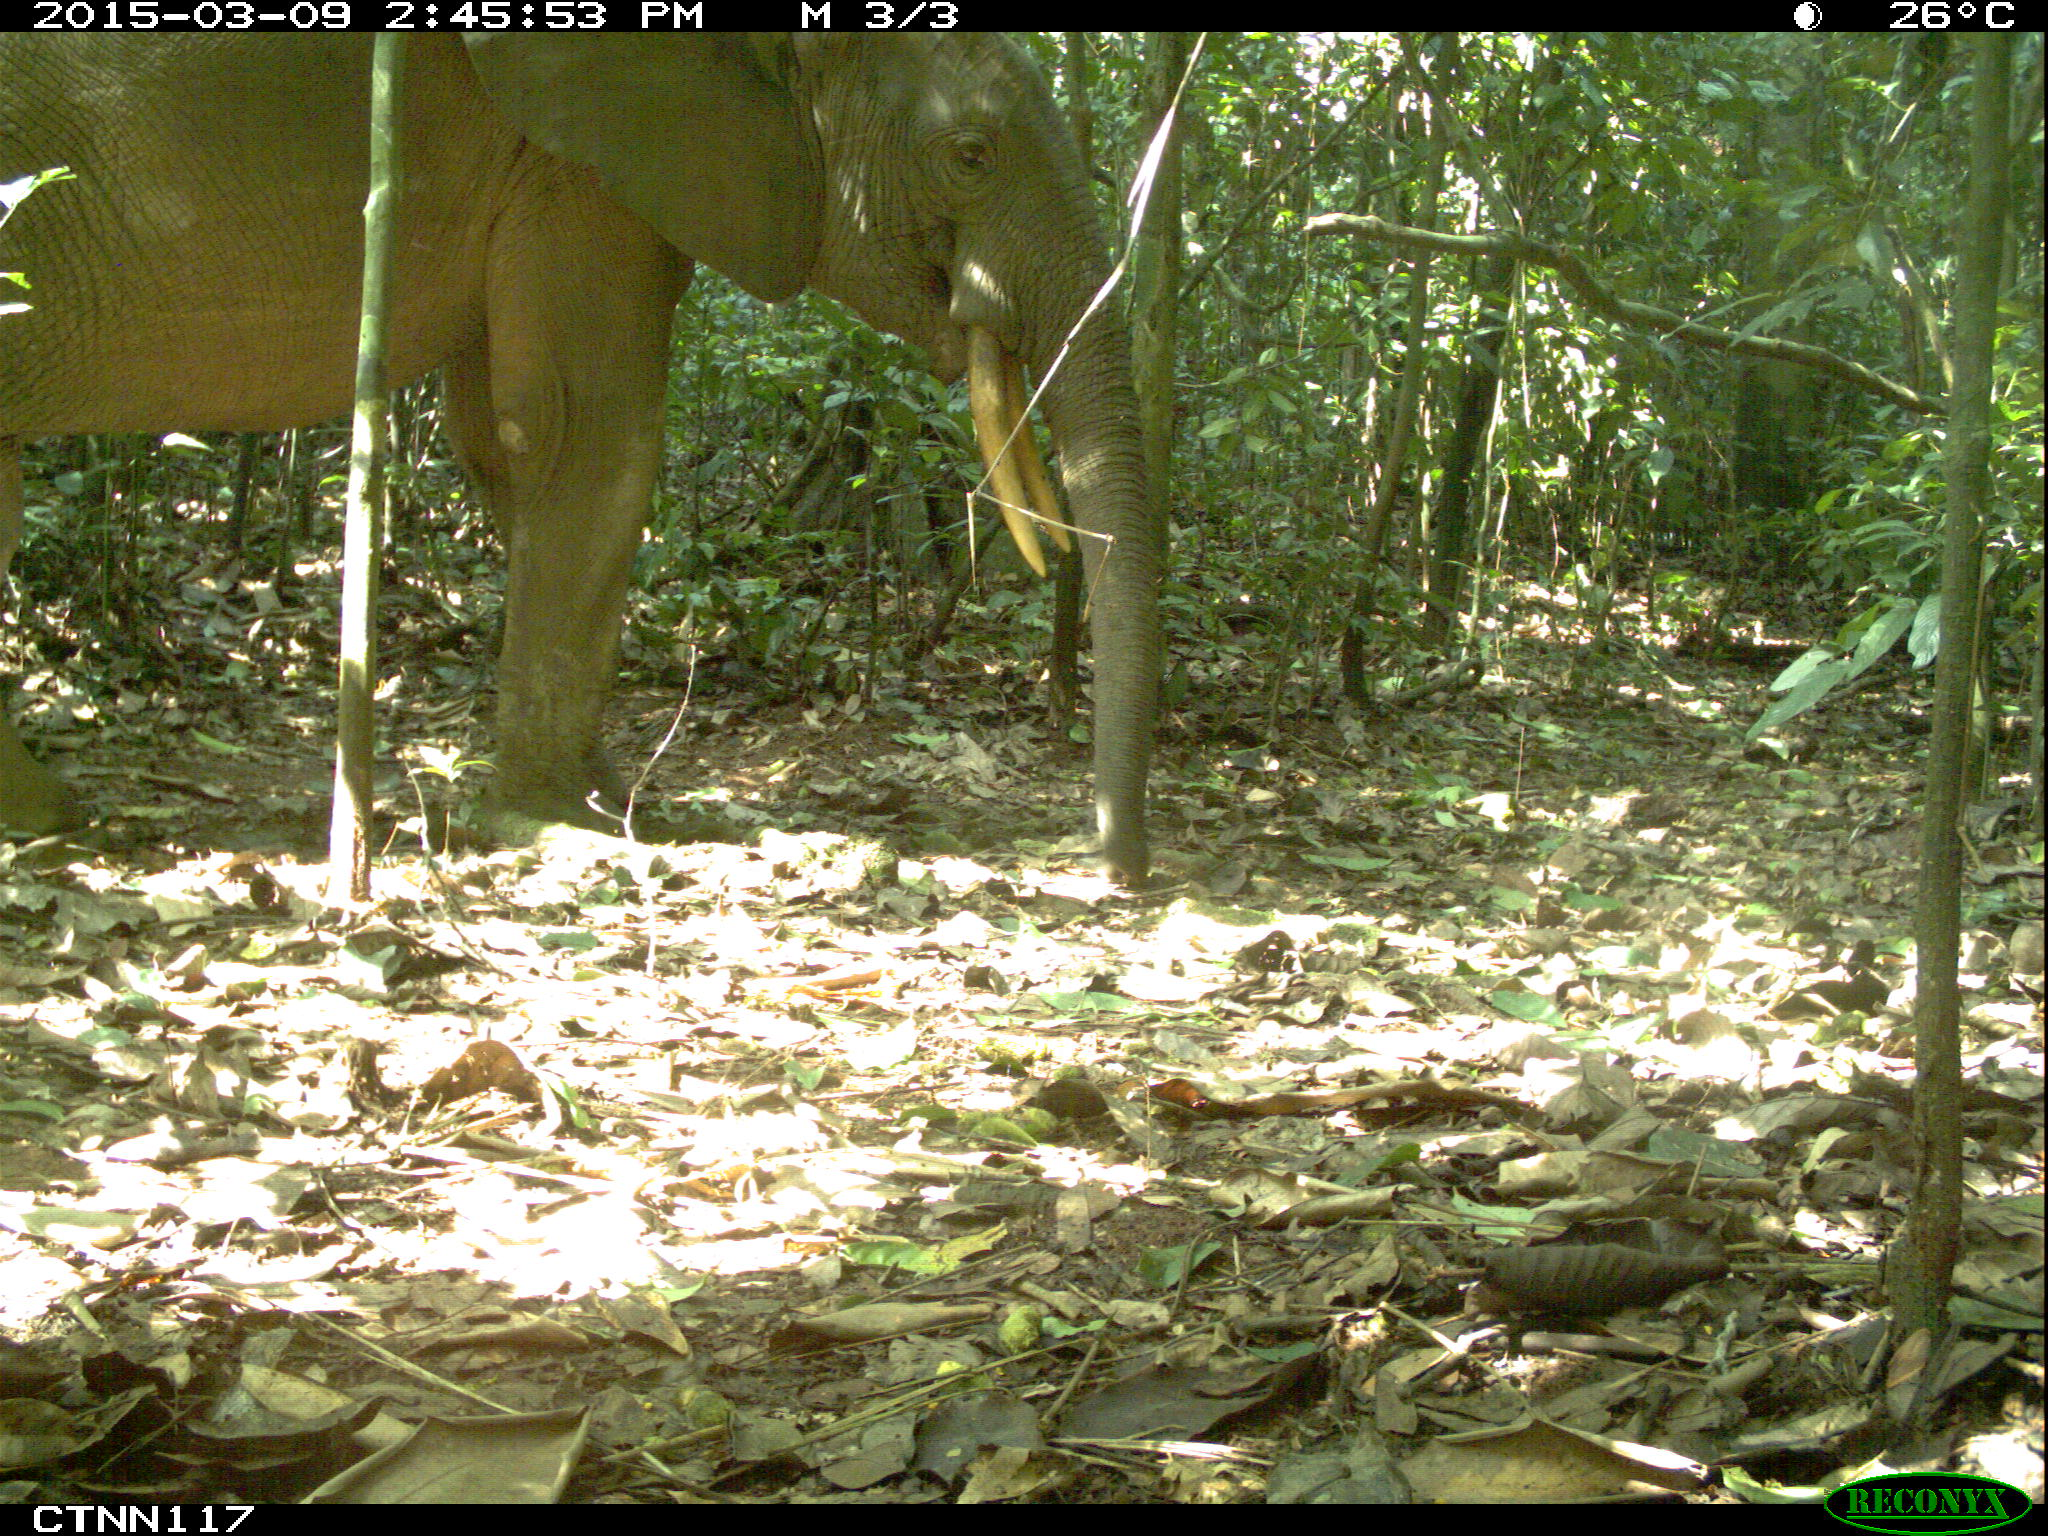

In [4]:
from IPython.display import Image
filename = "/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161115123529_3242/Terrestrial Vertebrate/NNN/2014.01/CT-NNN-1/CT-NNN-1-17/100-IMG_4191.JPG"
Image(filename) 

Image shape is: (1536, 2048, 3) of type uint8
Grayscale image shape is: (1536, 2048) of type uint8
Cropped grayscale image shape is: (850, 1200) of type uint8


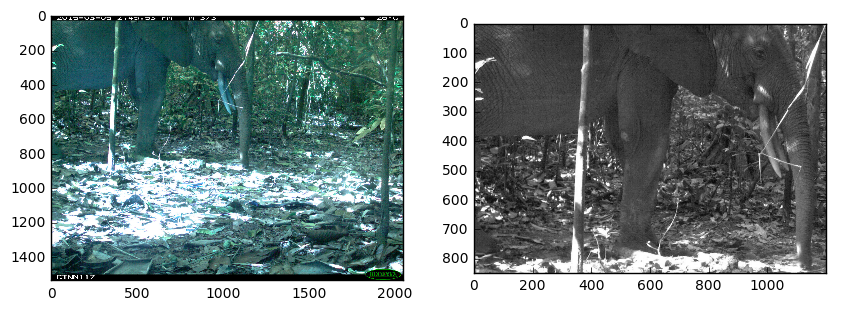

In [5]:
# read image to array
img = cv2.imread(filename)
print("Image shape is: {0} of type {1}".format(img.shape, img.dtype))

# read grayscale version to float array
im_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
print("Grayscale image shape is: {0} of type {1}".format(im_gray.shape, im_gray.dtype))

# capture the region that shows the elephant
img_rows, img_cols= 850, 1200

# create template to project cropped image of elephant
template = np.zeros([ img_rows, img_cols], dtype='uint8') # initialisation of the template
template[:, :] = im_gray[50:900,0:1200]
print("Cropped grayscale image shape is: {0} of type {1}".format(template.shape, template.dtype))

# plot the image
plt.subplots(figsize=(10, 7))
plt.subplot(121),plt.imshow(img); 
plt.subplot(122), plt.imshow(template, cmap='gray');

# Image Segmentation

## Graph Cut

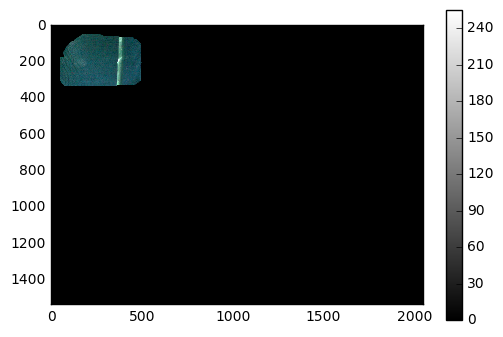

(<matplotlib.image.AxesImage at 0x139d4b710>,
 None)

In [18]:
# http://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_cut = img*mask2[:,:,np.newaxis]
plt.imshow(img_cut),plt.colorbar(),plt.show()

## Manual Crop

Created crop of shape: (725, 725)


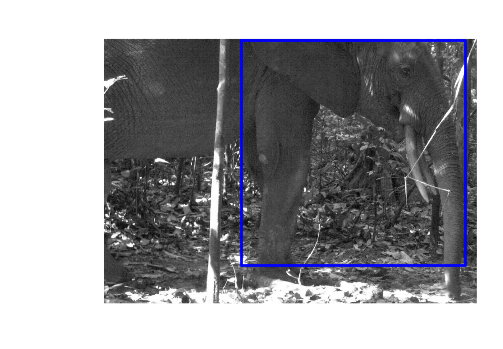

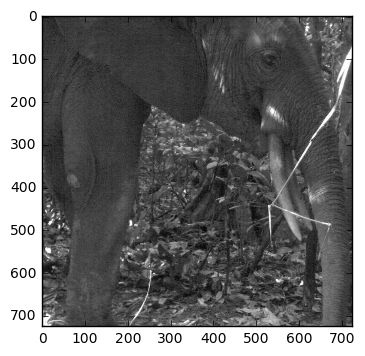

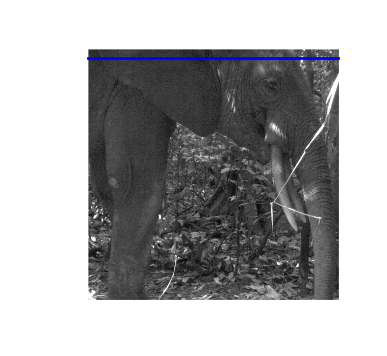

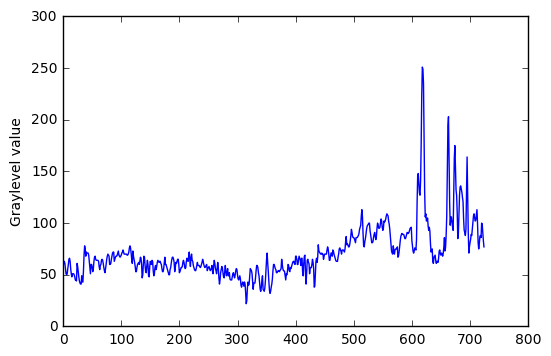

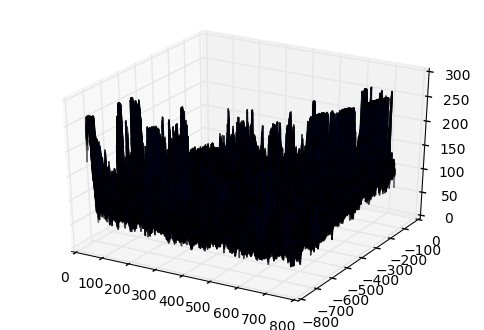

In [12]:
#https://github.com/jesolem/PCV/blob/master/examples2/ch1_image_representation.py

"""
This example shows how images are represented using pixels, color channels and data types.
"""

# visualize the pixel value of a small region
col_1, col_2 = 0, 725
row_1, row_2 = 440, 1165

# crop using array slicing
crop = template[col_1:col_2,row_1:row_2]
cols, rows = crop.shape

print("Created crop of shape: {0}".format(crop.shape))

# generate all the plots
plt.figure()
plt.imshow(template)
plt.gray()
plt.plot([row_1, row_2, row_2, row_1, row_1], [col_1, col_1, col_2, col_2, col_1], linewidth=2)
plt.axis('off')

plt.figure()
plt.imshow(crop)
plt.gray()
plt.axis('on')

plt.figure()
plt.imshow(crop)
plt.gray()
plt.plot(20*np.ones(cols), linewidth=2)
plt.axis('off')

plt.figure()
plt.plot(crop[20,:])
plt.ylabel("Graylevel value")

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
# surface plot with transparency 0.5
X,Y = np.meshgrid(np.arange(cols),-np.arange(rows)) 
ax.plot_surface(X, Y, crop, alpha=0.5, cstride=2, rstride=2)

plt.show()

# Feature Extraction

## Scale Invariant Feature Transform

SIFT interest point locations are found using difference-of-Gaussian functions

*D(x, σ) = [Gkσ (x) − Gσ (x)] ∗ I (x) = [Gkσ − Gσ ] ∗ I = Ikσ − Iσ *,

where *Gσ* is the Gaussian 2D kernel, *Iσ* the *Gσ* -blurred grayscale image, and *k*  is a constant factor determining the separation in scale. Interest points are the maxima and minima of *D(x, σ)* across both image location and scale. These candidate locations are filtered to remove unstable points. Points are dismissed based on a number of criteria, like low contrast and points on edges.

In [ ]:
# https://hackaday.io/project/10391-automated-elephant-detection-system

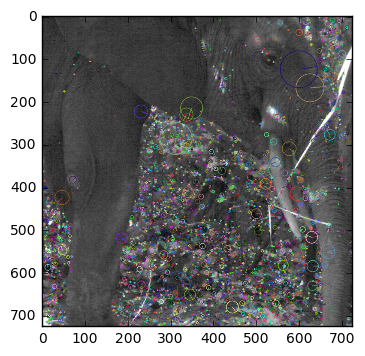

In [14]:
# OpenCV implementation
# Create a SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# Get the Key Points from the 'gray' image, this returns a numpy array
kp = sift.detect(crop, None)

# Now we drawn the gray image and overlay the Key Points (kp)
img = cv2.drawKeypoints(crop, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot it to the screen, looks a little small
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
# cyvlfeat implementation
# https://github.com/menpo/cyvlfeat
test = vl.sift.sift(im_gray)
print("SIFT keypoints in image shape is: {0} of type {1}".format(test.shape, test.dtype))
# plot the image
# plt.figure()
# plt.imshow(test)
# plt.gray()
# plt.axis('on')
# plt.show()

In [ ]:
# sift_pyocl implementation
# http://pythonhosted.org/sift_pyocl/sift.html

"""
This example shows an example using sift_pyocl.
"""
sift_pyocl.

img = scipy.misc.imread(filename)
sift_ocl = sift.SiftPlan(template=img)
kp = sift_ocl.keypoints(img)
kp.sort(order=["scale", "angle", "x", "y"])
print(kp)

In [ ]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
img = cv2.imread(filename)
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp,'sift.jpg')

## Histogram Comparison

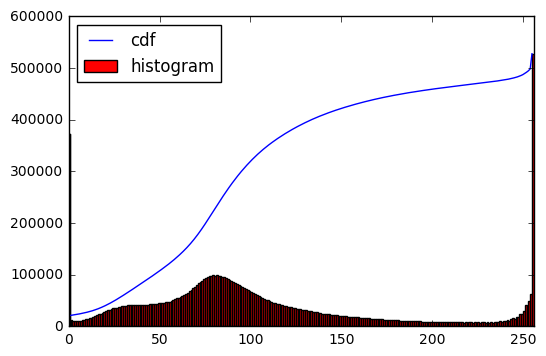

In [6]:
#http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

## Template Matching

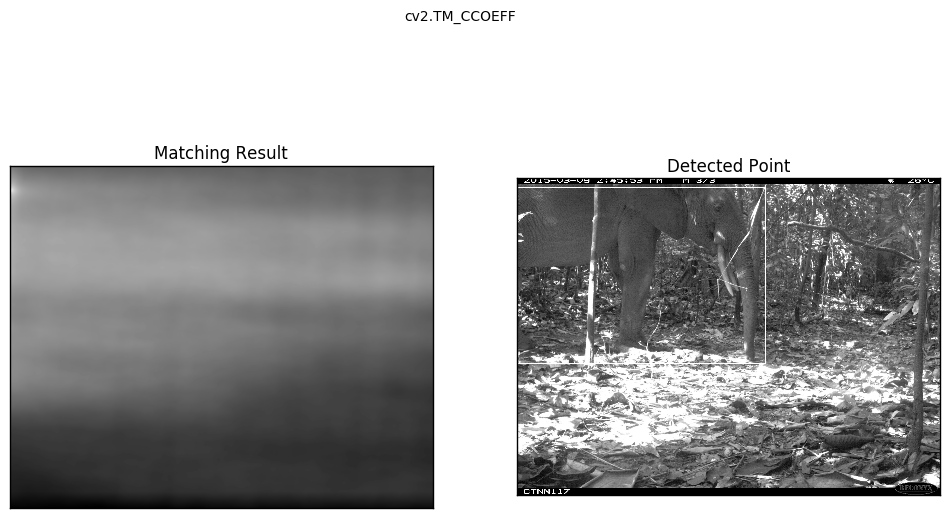

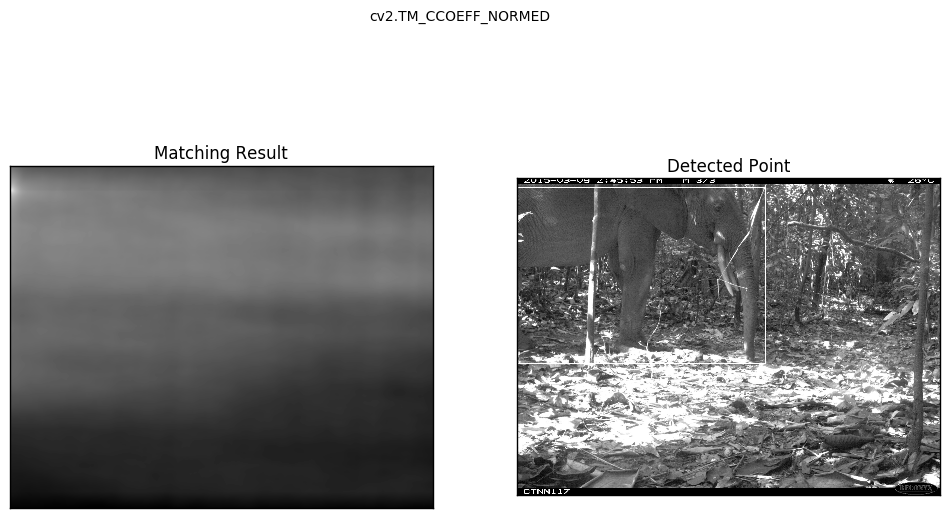

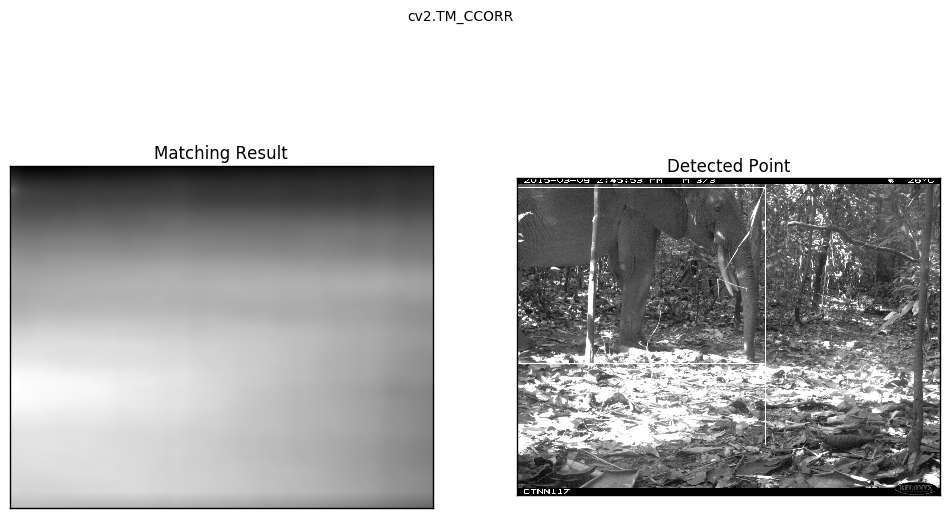

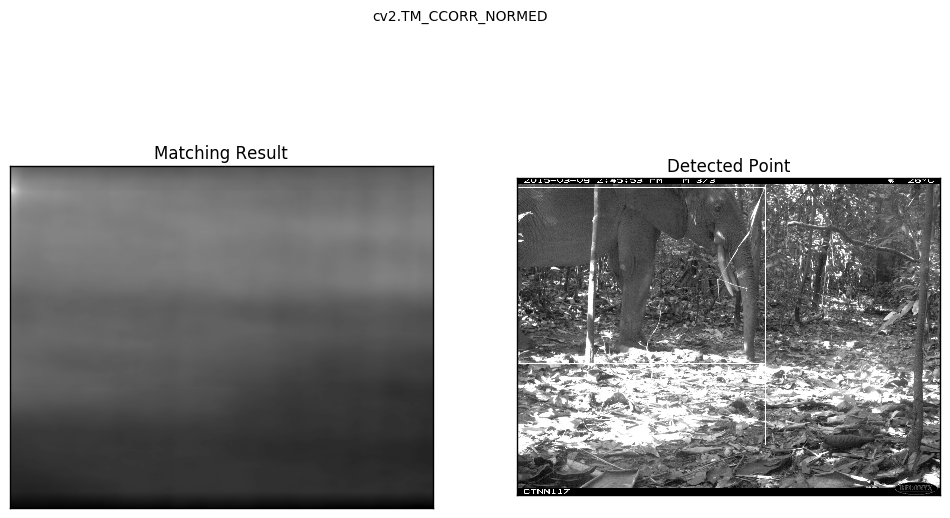

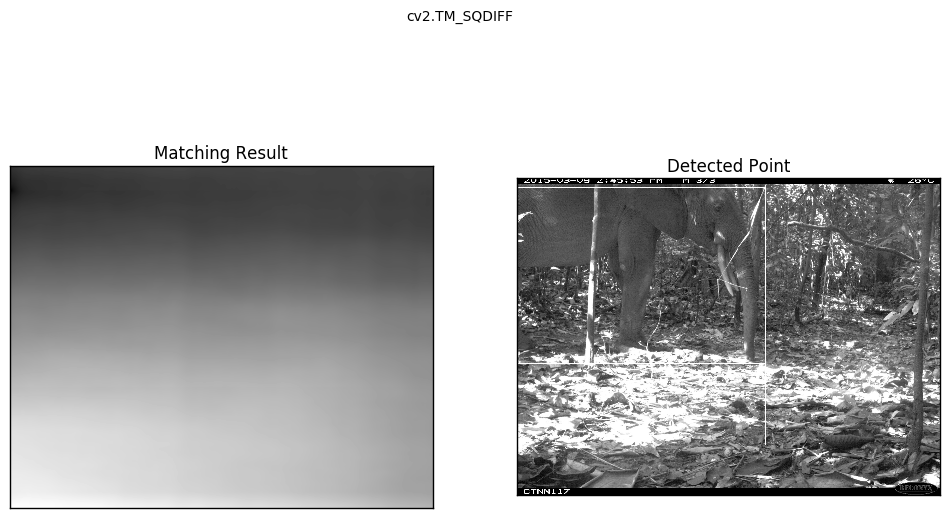

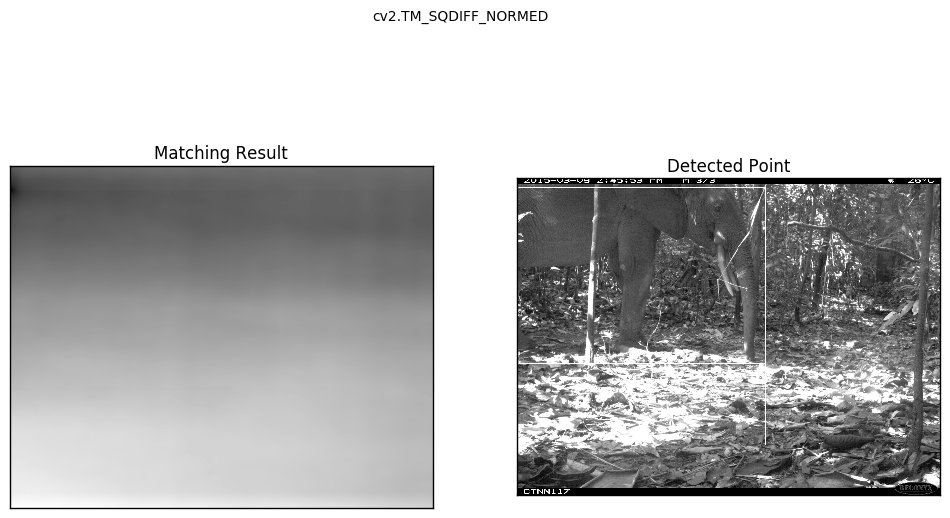

In [19]:
img = cv2.imread(filename,0) 
img2 = img
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2
    method = eval(meth)
 
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray') #,aspect='auto'
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [20]:
def get_images(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(DIRECTORY+species):
        for file in files:
            if file.endswith(".JPG"):
                images.append(file)
    return images

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im

files = []
y_all = []

for species in SPECIES_CLASSES:
    species_files = get_images(species)
    files.extend(species_files)

    y_species = np.tile(species, len(species_files))
    y_all.extend(y_species)
    print("{0} photos of {1}".format(len(species_files), species))
    
y_all = np.array(y_all)

258 photos of Loxodonta


In [21]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(files): 
    X_all[i] = read_image(DIRECTORY+species+'/'+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 258
(258, 180, 320, 3)


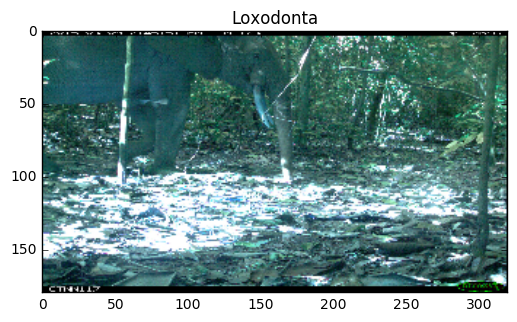

In [22]:
# check out a species from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [23]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

In [24]:
optimizer = RMSprop(lr=1e-4)
objective = 'sparse_categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(SPECIES_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, y_train, batch_size=64, nb_epoch=1,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

# Data Analysis & Exploration

In [25]:
# bb_metadata = pd.read_csv("data/TV-20161130134129_5302.csv", header=46,low_memory=False)
nnn_metadata = pd.read_csv("/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161205130624_1284/Terrestrial Vertebrate/TV-20161205130624_1284.csv", header=46,low_memory=False)
# vr_metadata = pd.read_csv("data/TV-20161204185054_1706.csv", header=46,low_memory=False)
# udz_metadata = pd.read_csv("data/TV-20161204185203_1536.csv", header=46,low_memory=False)

In [ ]:
df_metadata = pd.concat([bb_metadata, nnn_metadata, vr_metadata, udz_metadata])

In [26]:
nnn_metadata['Species'].count()

31485

In [27]:
directory = "/Users/Luxive/Dropbox/TEAM_Machine Learning/"

def count_images(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    i = 0
    for root, dirs, files in os.walk(directory+species):
        for file in files:
            if file.endswith(".JPG"):
                i += 1
    return i

actual_images = count_images(species)
print(actual_images)

31423


In [28]:
# expected versus actual images
series = pd.Series({"ExpectedImages": nnn_metadata['Species'].count(), "ActualImages": actual_images})
image_check = pd.DataFrame([series])
image_check['Difference'] = image_check['ExpectedImages'] - image_check['ActualImages']
image_check

ActualImages  ExpectedImages  Difference
0         31423           31485          62

In [29]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': nnn_metadata.isnull().sum(),
                        'data type' : nnn_metadata.dtypes,
                        'count': nnn_metadata.count()})
null_df

count data type  number of null values
ID                             31485     int64                      0
Site Name                      31485    object                      0
Sampling Unit Name             31485    object                      0
Latitude                       31485   float64                      0
Longitude                      31485   float64                      0
Sampling Period                31485   float64                      0
Photo Type                     31485    object                      0
Photo Date                     31485    object                      0
Photo Time                     31485    object                      0
Raw Name                       31485    object                      0
Photo Notes                        0   float64                  31485
Photo ID URL                   31485    object                      0
Class                          31485    object                      0
Order                          31485    object                      0
Family                         31485    object                      0
Genus                          31485    object                      0
Species                        31485    object                      0
Number of Animals              31485     int64                      0
Person Identifying the Photo   31485    object                      0
Camera Serial Number           31485    object                      0
Memory Card Serial Number      31485    object                      0
Camera Notes                    4503    object                  26982
Camera Start Date and Time     31485    object                      0
Camera End Date and Time       31485    object                      0
Person setting up the Camera   31485    object                      0
Person picking up the Camera   31485    object                      0
Camera Make                    25824    object                   5661
Camera Model                   25824    object                   5661
Flash                          25824   float64                   5661
Exposure Time                  31485    object                      0
Sequence Info                  27212    object                   4273
Triplet Number                 27212    object                   4273
Moon Phase                     27212    object                   4273
Temperature                    27212   float64                   4273
Camera Firmware Version        21551    object                   9934
Protocol Version               31485    object                      0
Data Set Creator Institutions  31485    object                      0
Data Set Creator Scientist     29037    object                   2448
Data Set Contact               31485    object                      0
Data Level                     31485    object                      0

In [30]:
# CSS styling within IPython notebook
from IPython.display import display, HTML
display(HTML(open('css/custom.css').read()))

## TEAM Terrestial Species Images Limitations
- Highly unbalanced classes of species
- Manually classified by experts in the field
- Context matters: busrts of images are understood by experts as a sequence of images containing the identified species (part of animal species v whole animal species in frame problem)
- Classification contain errors
- Existence of endangered species images preclude the use of citizen scientists to help classify images